## Comparing Value and Likelihood Function to calculate Regret


In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)
from src.utils.visualization import (
    plot_posterior_distribution,
    plot_environment,
    plot_trajectories,
    plot_log_likelihood,
)
from src.utils.constants import ParamTuple
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories

np.set_printoptions(linewidth=160, precision=2)

Create Environment


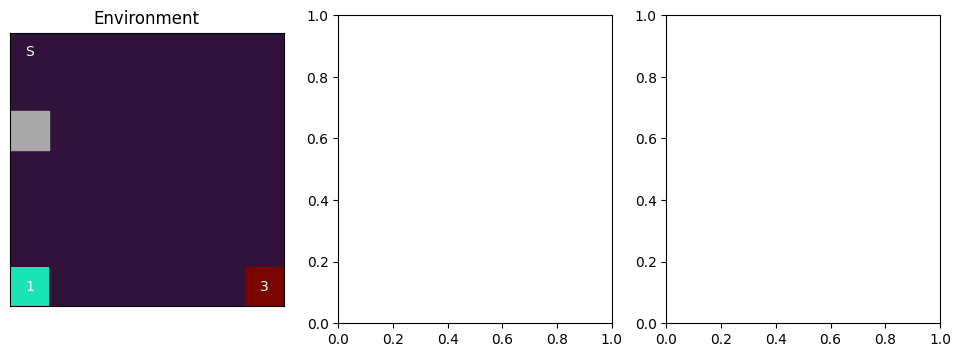

In [3]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 7,7
n_states, n_actions = N * M, 4

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 1
agent_R[N-1, M-1] = 3



# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.7
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

n_samples_MC = 1_000
n_burnin_MC = 500

# Generate 2 trajectories in the env starting environment
wall_states = [14]

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T=T_agent, wall_indices=wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)

env_agent = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_true=agent_R,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

# Generate trajectories
trajectories = generate_n_trajectories(
    env_agent.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_1 = [(env_agent, trajectories)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# # Show the trajectories
# plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# # Remove the colorbar from the second plot
# ax2.get_images()[0].colorbar.remove()

# plot_log_likelihood(
#     param_values=true_params,
#     expert_trajectories=expert_trajectories_1,
#     goal_states=goal_states,
#     ax=ax3,
# )

In [4]:
from src.utils.inference.posterior import PosteriorInference

In [5]:
posterior = PosteriorInference(expert_trajectories=expert_trajectories_1)
posterior.calculate_posterior(num_episodes=2)

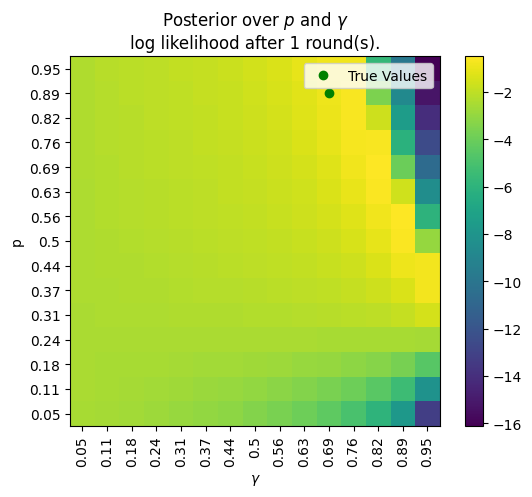

In [8]:
posterior.plot(episode=1, param_values=true_params)

### Create Candidate Environments, insert random walls

We insert 7 walls at random locations in 25 candidate environments.

In [7]:
n_walls = 5
n_candidate_envs = 10

# create candidate environment
candidate_envs = [
    Environment(
        N=N,
        M=M,
        T_true=T_true,
        wall_states=wall_states,
        R_sample_mean=None,
        start_state=0,
        n_walls=None,
    )
    for _ in range(n_candidate_envs)
]

for idx, candidate_env in enumerate(candidate_envs):
    # update T
    wall_incides = np.random.randint(1, N*M-1, size=n_walls)
    wall_incides = np.append(wall_incides, 14)

    _T = insert_walls_into_T(
        candidate_env.T_true, wall_indices=wall_incides
    )
    candidate_env.T_true = _T

    #append wall to list of walls of that environment
    candidate_env.wall_states = wall_incides

TypeError: Environment.__init__() missing 1 required positional argument: 'goal_states'

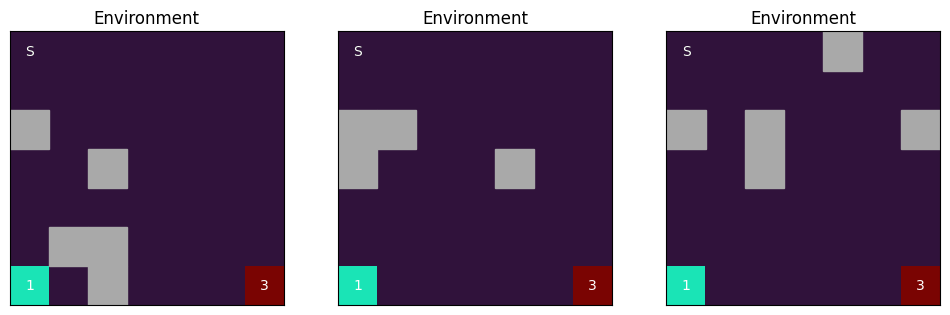

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_environment(agent_R.reshape(N, M), candidate_envs[7].wall_states, ax=ax1)
plot_environment(agent_R.reshape(N, M), candidate_envs[8].wall_states, ax=ax2)
plot_environment(agent_R.reshape(N, M), candidate_envs[9].wall_states, ax=ax3)

Calculate potential Posterior in candidate environment if we had 2 expert trajectories in that environment.


In [ ]:
from src.utils.make_environment import Environment

In [ ]:
def plot_posterior_for_env(env: Environment):
    print("Regret: ", env.regret)
    print("Log Regret: ", env.log_regret)
    print("Wall States: ", env.wall_states)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
    T_true = insert_walls_into_T(T_true, wall_indices=env.wall_states)
    env.T_true = T_true
    T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
    T_agent = insert_walls_into_T(T_agent, wall_indices=env.wall_states)
    agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)

    # Generate trajectories
    trajectories = generate_n_trajectories(
        env.T_true,  # shouldnt this be T_true?
        agent_policy,
        goal_states,
        n_trajectories=2,
    )

    expert_trajectories_1 = [(env, trajectories)]

    plot_environment(
        agent_R.reshape(N, M),
        env.wall_states,
        start_state=(env.start_state // M, env.start_state % M),
        ax=ax1,
    )

    # Show the trajectories
    plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

    # Remove the colorbar from the second plot
    ax2.get_images()[0].colorbar.remove()

    plot_log_likelihood(
        param_values=true_params,
        expert_trajectories=expert_trajectories_1,
        goal_states=goal_states,
        ax=ax3,
    )

In [ ]:
from src.utils.inference.sampling import bayesian_parameter_learning
from src.utils.environment_design import environment_search

posterior_samples_1 = bayesian_parameter_learning(
    expert_trajectories=expert_trajectories_1,
    sample_size=n_samples_MC,
    goal_states=goal_states,
    n_states=n_states,
)
posterior_samples_1 = posterior_samples_1[-250:]

# plot_posterior_distribution(
#     posterior_samples=posterior_samples_1,
#     N=N,
#     M=M,
#     absorbing_states=goal_states,
#     true_params=true_params,
# )

Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s, Acceptance rate=100, step_size=0.1]

## Calculate likelihood and value based regret for this environment


Calculate the regret of the environments using the value function

We learn only p and gamma


In [ ]:
envs_value = environment_search(
    N=N,
    M=M,
    goal_states=goal_states,
    posterior_samples=posterior_samples_1,
    n_traj_per_sample=2,
    candidate_envs=candidate_envs,
    how="value",
    agent_R=agent_R,
)

Evaluating candidate environments using value:   0%|          | 0/10 [00:00<?, ?it/s, highest_regret=-inf]

Evaluating candidate environments using value: 100%|██████████| 10/10 [01:54<00:00, 11.46s/it, highest_regret=0.122]


Plot highest and lowest regret environments for value and likelihood

Regret:  0.12180734939227267
Log Regret:  None
Wall States:  [43  8 24  5  8 14]


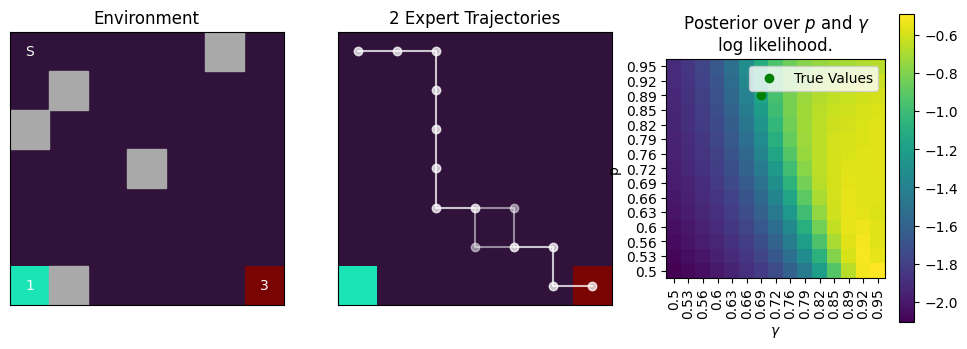

In [ ]:
plot_posterior_for_env(envs_value[0])

Update Posterior by observing agent in maximum regret environment

In [ ]:
max_regret_env_2_value = envs_value[0]

#Get policy of agent in max regret environment
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=max_regret_env_2_value.wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)

#Generate trajectories according to that policy in max regret environment
trajectories_2_max_regret = generate_n_trajectories(
    max_regret_env_2_value.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

#Add trajectories
expert_trajectories_value = expert_trajectories_1
expert_trajectories_value.append([max_regret_env_2_value, trajectories_2_max_regret])


#Sample new parameters
posterior_samples_2_value = bayesian_parameter_learning(
    expert_trajectories=expert_trajectories_value,
    sample_size=n_samples_MC,
    goal_states=goal_states,
    n_states=n_states,
)
posterior_samples_2_value = posterior_samples_2_value[-250:]

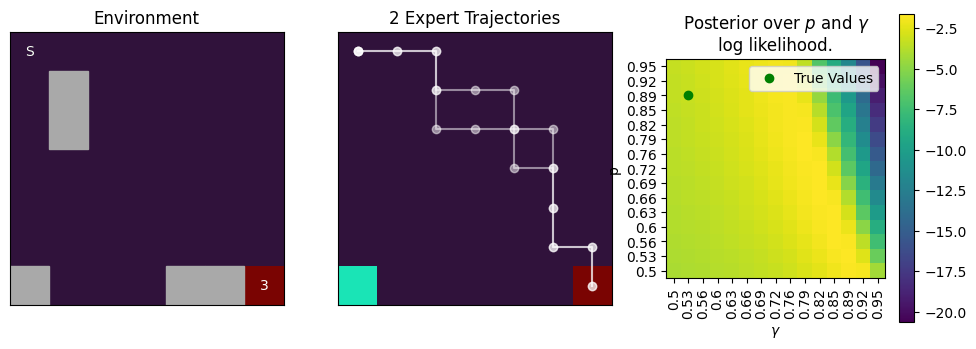

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_environment(
    agent_R.reshape(N, M),
    max_regret_env_2_value.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_2_max_regret, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

plot_log_likelihood(
    param_values=true_params,
    expert_trajectories=expert_trajectories_value,
    goal_states=goal_states,
    ax=ax3,
)

### Second Round

Generate Candidate Environments

In [ ]:
n_walls = 5
n_candidate_envs = 25

# create candidate environment
candidate_envs = [
    Environment(
        N=N,
        M=M,
        T_true=T_true,
        wall_states=wall_states,
        R_sample_mean=None,
        start_state=0,
        n_walls=None,
    )
    for _ in range(n_candidate_envs)
]

for idx, candidate_env in enumerate(candidate_envs):
    # update T
    wall_incides = np.random.randint(1, N*M-1, size=n_walls)
    _T = insert_walls_into_T(
        candidate_env.T_true, wall_indices=wall_incides
    )
    candidate_env.T_true = _T

    #append wall to list of walls of that environment
    candidate_env.wall_states = wall_incides

In [ ]:
envs_value = environment_search(
    N=N,
    M=M,
    goal_states=goal_states,
    posterior_samples=posterior_samples_2_value,
    n_traj_per_sample=2,
    candidate_envs=candidate_envs,
    how="value",
    agent_R=agent_R,
)

Evaluating candidate environments using value:  64%|██████▍   | 16/25 [02:31<01:25,  9.49s/it, highest_regret=0.108]


KeyboardInterrupt: 

Environment Search via Behavior Maps

In [ ]:
# create candidate environment
candidate_envs_BM = []

#Environment with extra wall to make small reward further away.
env_1 = Environment(
        N=N,
        M=M,
        T_true=T_true,
        wall_states=[14, 15],
        R_sample_mean=None,
        start_state=0,
        n_walls=None,
    )

_T = insert_walls_into_T(
    candidate_env.T_true, wall_indices=[14, 15]
)
candidate_env.T_true = _T

candidate_envs_BM.append(env_1)


#Environment with death state to make small reward riskier.




In [ ]:
max_regret_env_BM = candidate_envs_BM[0]

#Get policy of agent in max regret environment
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
T_agent = insert_walls_into_T(T_agent, wall_indices=max_regret_env_BM.wall_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)

#Generate trajectories according to that policy in max regret environment
trajectories_BM = generate_n_trajectories(
    max_regret_env_BM.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

#Add trajectories
expert_trajectories_BM = expert_trajectories_1
expert_trajectories_BM.append([max_regret_env_BM, trajectories_BM])


# #Sample new parameters
# posterior_samples_2_value = bayesian_parameter_learning(
#     expert_trajectories=expert_trajectories_BM,
#     sample_size=n_samples_MC,
#     goal_states=goal_states,
#     n_states=n_states,
# )
# posterior_samples_2_value = posterior_samples_2_value[-250:]

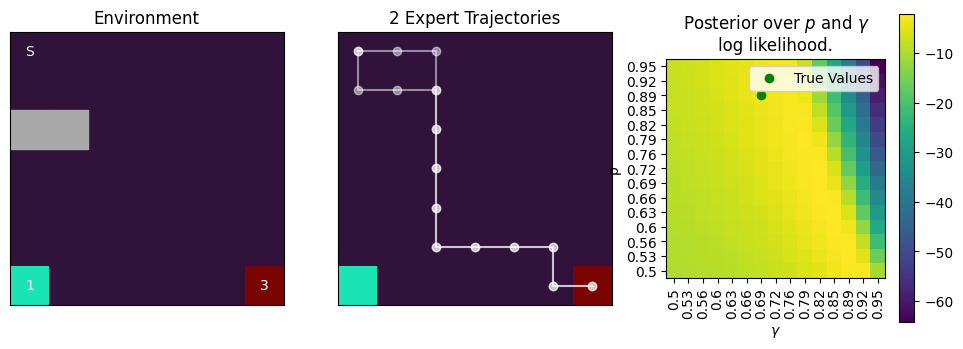

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_environment(
    agent_R.reshape(N, M),
    max_regret_env_BM.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories_BM, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

plot_log_likelihood(
    param_values=true_params,
    expert_trajectories=expert_trajectories_BM,
    goal_states=goal_states,
    ax=ax3,
)